# Implementation of a Full-Quantum-Boltzmann-Machine (QRBM) on Dynex

Implementation of the Quantum-Boltzmann-Machine (QRBM), utilising Dynex' Neuromorphic Computing platform. All training samples are being sampled on the Dynex platform with no Gibbs or CD steps (full QRBM). It is based on https://cmst.eu/articles/applying-a-quantum-annealing-based-restricted-boltzmann-machine-for-mnist-handwritten-digit-classification/

1. sampling probabilities of hidden units on the Dynex platform
2. sampling reconstruction v' from visible units on the Dynex platform
3. resampling hidden activations h' from v' on the Dynex platform

After each training batch (or as configured), a training sample is reconstructed with the Dynex platform and the MSE measured:

- reconstructing data to calculate MSE on the Dynex platform

This approach converges extremely fast to a low MSE. The size of the training samples is almost unlimited, but keep in mind that each data sample is being sampled on the Dynex platform.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dynex
import dimod

In [3]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [4]:
import DynexQRBM.QRBM as QRBM

## Load Data

In [5]:
# load MNIST data:
MNIST = pickle.load(open("datasets/MNIST.pickle", 'rb'))
MNIST_test = pickle.load(open("datasets/MNIST_test.pickle", 'rb'))

In [6]:
digits = [0,1,2,3,4,5,6,7,8,9]
X = [];
y = [];
y_class = [];
for digit in digits:
    for img in MNIST[digit]:
        X.append(img);
        labels = [0] * len(digits); # labels are converted into binary values of len(labels)
        labels[digit] = 1;
        y.append(labels);
        y_class.append(digit);

X_val = [];
y_val = [];
y_val_class = [];

for digit in digits:
    for img in MNIST_test[digit]:
        X_val.append(img);
        labels = [0] * len(digits); # labels are converted into binary values of len(labels)
        labels[digit] = 1;
        y_val.append(labels);
        y_val_class.append(digit)

X = np.array(X);
X_val = np.array(X_val);
y = np.array(y);
y_val = np.array(y_val);
print('training data:',X.shape ,'labels:',y.shape,'validation data:',X_val.shape,'labels:',y_val.shape)


training data: (60000, 784) labels: (60000, 10) validation data: (10000, 784) labels: (10000, 10)


## Setting up the QRBM

In [7]:
qrbm = QRBM.DYNEX_QRBM(n_visible = X.shape[1]+y.shape[1],  # features + labels
                       n_hidden  = 300, #160,
                       num_reads = 50000, #100,
                       annealing_time = 2000, 
                       mainnet=True, #False, 
                       minimum_stepsize = 0.00000006, 
                       logging=False, 
                       debugging=False,
                       seed = 50390,
                       description = 'Dynex SDK Job'
                     )

SEED SET TO 50390


## Training

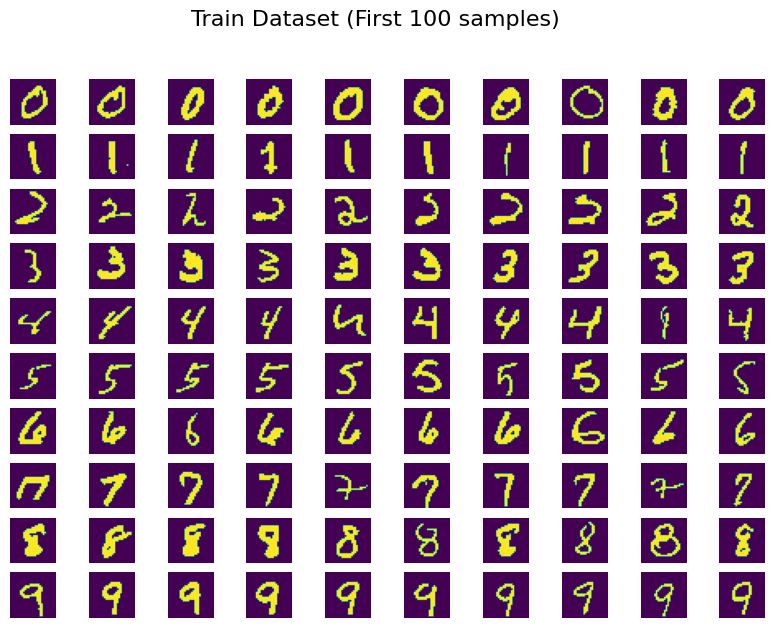

In [11]:
trainlength = 10;

X_one = np.vstack((np.array(X[:trainlength]), 
                   np.array(X[7000:7000+trainlength]), 
                   np.array(X[14000:14000+trainlength]), 
                   np.array(X[21000:21000+trainlength]),
                   np.array(X[28000:28000+trainlength]),
                   np.array(X[35000:35000+trainlength]),
                   np.array(X[40000:40000+trainlength]),
                   np.array(X[45000:45000+trainlength]),
                   np.array(X[49000:49000+trainlength]),
                   np.array(X[57000:57000+trainlength]),
                   ))  

y_one = np.vstack((np.array(y[:trainlength]), 
                   np.array(y[7000:7000+trainlength]), 
                   np.array(y[14000:14000+trainlength]), 
                   np.array(y[21000:21000+trainlength]),
                   np.array(y[28000:28000+trainlength]),
                   np.array(y[35000:35000+trainlength]),
                   np.array(y[40000:40000+trainlength]),
                   np.array(y[45000:45000+trainlength]),
                   np.array(y[49000:49000+trainlength]),
                   np.array(y[57000:57000+trainlength]),
                   ))  

fig = plt.figure(figsize=(10, 7));
fig.suptitle('Train Dataset (First 100 samples)', fontsize=16)
rows = 10;
columns = 10;

for j in range(0,100):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(X_one[j].reshape(28, -1))
    plt.axis('off');
    
plt.show();

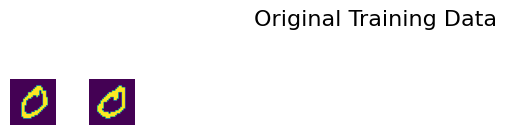

In [12]:
# test images:
trainlength = 2;
X_one = np.vstack((np.array(X[:trainlength])
                  ))
y_one = np.vstack((np.array(y[:trainlength])
                  ))

fig = plt.figure(figsize=(10, 7));
fig.suptitle('Original Training Data', fontsize=16)
rows = 10;
columns = 10;

for j in range(0,len(X_one)):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(X_one[j].reshape(28, -1))
    plt.axis('off');
    
plt.show();

With this model, each training sample is being sampled on the Dynex Platform (as described above). We can define a training stop once a certain level of MSE is being reached (stop_at_mse = 0.0). We can also define how often the MSE is being updated (each MSE calculation requires one sampling step on the Dynex platform (mse_every_epochs = 1).

In [13]:
qrbm.train(
    training_data = X_one,
    training_labels = y_one,
    epochs = 10, 
    lr = 0.1, 
    lr_decay= 0.1, 
    epoch_drop = None, # default epochs/5; drops learning rate every X training steps
    momentum = 0, #  Let the update to the weight matrix W be the positive gradient minus the negative gradient
    batch_size = trainlength, # should equal number of train samples in parallel environment; all samples are processed in one batch together
    autosave = False,
    stop_at_mse = 0.0,
    plot_reconstructed_images = False,
    mse_every_epochs = 1 # every x epochs the MSE is calculated (needs QUBO)
    )

 40%|███████████████████████████████████▌                                                     | 4/10 [04:39<05:49, 58.19s/it, MSE=0.00383, MSE(best)=0.00383, INFO=[2/2][3/3] resampling hidden activations h' from v']

[DYNEX] OMITTED SOLUTION FILE: 24559449b283362c59386a9aa35368b5.bin.49984.2000.1.48.00  - INCORRECT DATA


 50%|██████████████████████████████████████████▌                                          | 5/10 [05:07<04:49, 57.87s/it, MSE=0.0242, MSE(best)=0.00383, INFO=[1/2][2/3] sampling reconstruction v' from visible units]

[DYNEX] OMITTED SOLUTION FILE: 07ff1d269c2b85ad0514dc9f9a6c9a02.bin.49984.2000.1.103.00  - INCORRECT DATA


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [06:56<04:37, 69.36s/it, MSE=0, MSE(best)=0, INFO=TRAINING STOPPED WITH MSE 0.0]


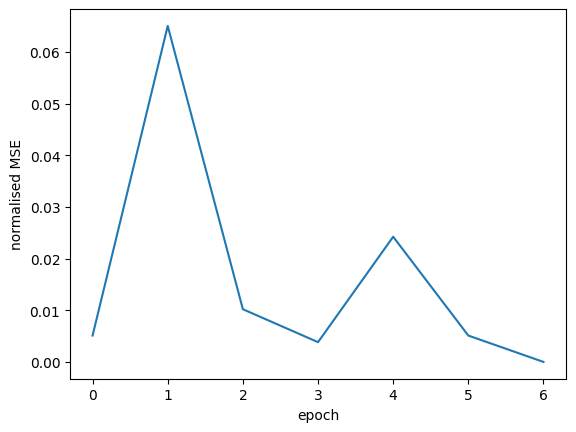

[0.00510204081632653, 0.06505102040816327, 0.01020408163265306, 0.003826530612244898, 0.02423469387755102, 0.00510204081632653, 0.0]


In [14]:
#plot
plt.figure()
plt.plot(qrbm.mse)
plt.xlabel('epoch')
plt.ylabel('normalised MSE')
plt.show()
print(qrbm.mse)

## Reconstruct and Predict with QUBO

In [15]:
pred_data, pred_labels = qrbm.generate(X_one[0])

predicted labels= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mse =  0.0625


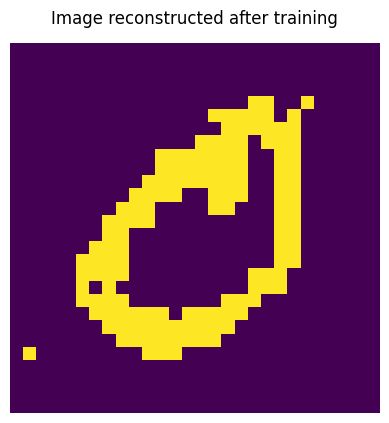

In [16]:
plt.figure()
plt.axis('off')
plt.title("Image reconstructed after training", y=1.03)
plt.imshow(np.array(pred_data).reshape(28, -1))
print('predicted labels=',pred_labels)
mse = np.sum((np.array(X_one[0]) - np.array(pred_data))**2 ) / (qrbm.num_features); # normalized
print('mse = ',mse)

## Predict with Contrastive Divergence Infer

In [17]:
predictions, _ = qrbm.predict(X_one, num_particles = 100, num_gibbs_updates = 10)
predictions = pd.DataFrame(predictions, columns=digits)
predictions

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.017947,0.003854,6.104467e-09,0.292890,1.159455e-06,1.053810e-07,0.019905,0.005867,3.410294e-07
1,1.0,0.035127,0.001692,3.158551e-09,0.023198,5.805162e-07,7.109480e-07,0.002725,0.047967,3.614008e-08


In [18]:
m = np.zeros_like(predictions.values)
m[np.arange(len(predictions)), predictions.values.argmax(1)] = 1
pd.DataFrame(m, columns = predictions.columns).astype(int)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0


## Reconstruct features

In [19]:
_, features = qrbm.predict(X_one, num_particles = 100, num_gibbs_updates = 1)

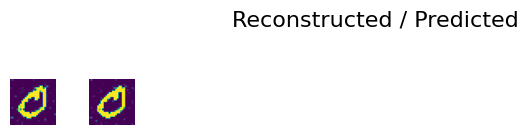

In [20]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed / Predicted', fontsize=16)
rows = 10;
columns = 10;

for j in range(0,len(features)):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(features[j].reshape(28, -1))
    #marker=str(y_one[j])
    #plt.title(marker)
    plt.axis('off');
    
plt.show();

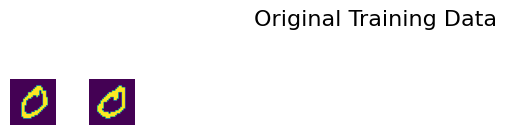

In [21]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Original Training Data', fontsize=16)
rows = 10;
columns = 10;

for j in range(0,len(X_one)):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(X_one[j].reshape(28, -1))
    plt.axis('off');
    
plt.show();

## Save Model

In [22]:
qrbm.save('model.bin');

## Load Model

In [23]:
qrbm.load(filename='model.bin');

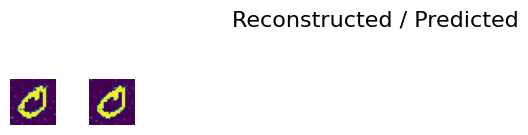

In [24]:
_, features = qrbm.predict(X_one, num_particles = 100, num_gibbs_updates = 1)
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed / Predicted', fontsize=16)
rows = 10;
columns = 10;

for j in range(0,len(features)):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(features[j].reshape(28, -1))
    #marker=str(y_one[j])
    #plt.title(marker)
    plt.axis('off');
    
plt.show();